## Setup and Libraries

Before diving into the analysis of parameters, we need to import the necessary Python libraries:

- `numpy`, `pandas` — for numerical operations and data handling
- `matplotlib` — for plotting graphs
- `scipy.optimize.curve_fit` and `scipy.integrate.quad` — for fitting cosmological models and integrating equations
- `astropy.constants` and `astropy.units` — for physical constants and unit conversions

`pip install numpy pandas matplotlib scipy astropy`

In [1]:
#Import necessary libraries for data handling, optimization, and plotting

import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.integrate import quad
import matplotlib.pyplot as plt
from astropy import constants as const  #we will mainly use speed of light
from astropy import units as u  #related to c, light-year, etc.


## Extracting Meaningful Data from Pantheon

The data is downloaded from [Pantheon dataset](https://github.com/PantheonPlusSH0ES/DataRelease/blob/main/Pantheon%2B_Data/4_DISTANCES_AND_COVAR/Pantheon%2BSH0ES.dat) and available locally `Pantheon Shoes.data`. 

- We use `delim_whitespace = True` because the file is space-delimited rather than comma-separated.
- Commented rows (starting with `#`) are automatically skipped.
The first few rows of the table is given as an example.

In [2]:
df = pd.read_csv('Pantheon Shoes.dat', delimiter=' ')
pd.options.display.max_columns = 5  #limits the number of columns displayed
df.head()   #Print the first few rows of the DataFrame to check the data

,CID,IDSURVEY,...,biasCor_m_b_COVSCALE,biasCor_m_b_COVADD
0,2011fe,51,...,1.0,0.003
1,2011fe,56,...,1.0,0.004
2,2012cg,51,...,1.0,0.036
3,2012cg,56,...,1.0,0.040
4,1994DRichmond,50,...,1.0,0.006


Now let us isolate the columns, only keeping the meaningful quantities for this experiment, which are:

- Redshift `zHD`
- Distance Modulus `MU_SH0ES`
- Error in Distance Modulus `MU_SH0ES_ERR_DIAG`

We will call this new set of columns `selected_columns`. 

In [3]:
selected_columns = df[['zHD', 'MU_SH0ES', 'MU_SH0ES_ERR_DIAG']]
selected_columns.head()

,zHD,MU_SH0ES,MU_SH0ES_ERR_DIAG
0,0.00122,28.9987,1.516450
1,0.00122,29.0559,1.517470
2,0.00256,30.7233,0.782372
3,0.00256,30.7449,0.799068
4,0.00299,30.7757,0.881212


Since we have the relevant data, we can try a quick plot to observe the trend of which distance modulus has with redshift. 

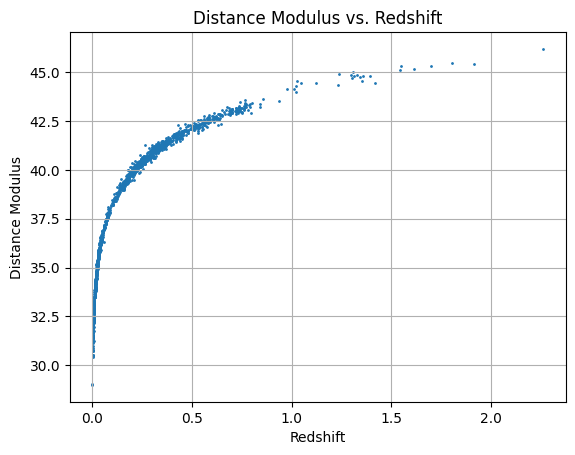

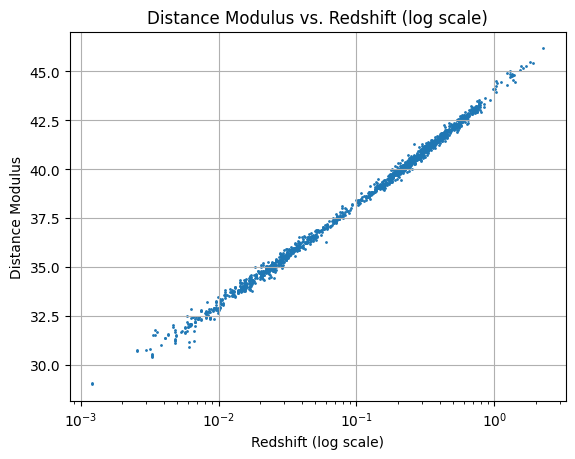

In [4]:
#Ordinary scatter plot of distance modulus vs redshift
selected_columns.plot(
    x=selected_columns.columns[0],  #choosing redshift as x-axis
    y=selected_columns.columns[1],  #choosing distance modulus as y-axis
    kind='scatter', #scatter plot
    s=1,  # size of the dots
)
plt.xlabel('Redshift')
plt.ylabel('Distance Modulus') 
plt.title('Distance Modulus vs. Redshift')
plt.grid()
plt.show()  

#Along side let us plot the x-axis in log scale
selected_columns.plot(
    x=selected_columns.columns[0],
    y=selected_columns.columns[1],
    kind='scatter',
    logx=True,  #The only change here is logx=True to set x-axis to log scale
    s=1
)
plt.xlabel('Redshift (log scale)')
plt.ylabel('Distance Modulus')
plt.title('Distance Modulus vs. Redshift (log scale)')
plt.grid()
plt.show()

## Defining the Cosmological Model

With this tabulated data, we must first convert all of it into numpy arrays so that we can perform any mathematical functions we wish to analyse, for which the dataset is the input. Let us call our three important quantities redshift `z`, distance modulus `mu`, and associated error `mu_error`. 

In [5]:
#Using numpy to extract the data from the DataFrame
z = np.array(selected_columns['zHD'])   #Redshift values
mu = np.array(selected_columns['MU_SH0ES']) #Distance modulus values
mu_err = np.array(selected_columns['MU_SH0ES_ERR_DIAG']) #Distance modulus errors

We now define the theoretical framework based on the flat $\Lambda\mathrm{CDM}$ model. This involves:

- The dimensionless Hubble parameter:
  $$
  E(z) = \sqrt{\Omega_m (1+z)^3 + (1 - \Omega_m)}
  $$

- The distance modulus is:
  $$
  \mu(z) = 5 \log_{10}(d_L / \text{Mpc}) + 25
  $$

- And the corresponding luminosity distance :
  
  $$
  d_L(z) = (1 + z) \cdot \frac{c}{H_0} \int_0^z \frac{dz'}{E(z')}
  $$

These equations allow us to compute the expected distance modulus from a given redshift $z$, Hubble constant $H_0$, and matter density parameter $\Omega_m$. Let us create respective functions to use later on.

In [6]:
def E(z, Omega_m):
    return np.sqrt(Omega_m * (1 + z)**3 + (1 - Omega_m))

def luminosity_distance(z, H0, Omega_m):
    c = const.c.to('km/s').value  # speed of light in km/s

    def integrand(zp):
        return 1 / E(zp, Omega_m)

    integral, _ = quad(integrand, 0, z)
    dL = (1 + z) * (c / H0) * integral  # result in Mpc
    return dL

def mu_theory(z, H0, Omega_m):
    dL = np.array([luminosity_distance(zi, H0, Omega_m) for zi in np.atleast_1d(z)])    #for each redshift value, calculate the luminosity distance 
    return 5 * np.log10(dL) + 25

## Curve Fitting and Attaining Hubble Parameters

Using the scipy curve fitting method, we will first guess the constants $H_0$ and $\Omega_m$, then fit our theoretical model to the data to determine the optimized hubble parameters.

In [7]:
# Initial guesses for H0 and Omega_m
p0 = [70, 0.3]

# Perform the curve fit
popt, pcov = curve_fit(
    mu_theory,  #theotical model function
    z,    #redshift values
    mu,   #distance modulus values
    sigma=mu_err,     #errors in distance modulus
    p0=p0,  #initial guess for parameters
    absolute_sigma=True,    #use absolute errors
    maxfev=10000    #maximum number of function evaluations
)
perr = np.sqrt(np.diag(pcov))   #standard deviation of the fitted parameters

print(f"Fitted Hubble Constant H0 = {popt[0]:.2f} ± {perr[0]:.2f} km/s/Mpc")
print(f"Fitted Omega_m = {popt[1]:.3f} ± {perr[1]:.3f}")

Fitted Hubble Constant H0 = 72.97 ± 0.26 km/s/Mpc
Fitted Omega_m = 0.351 ± 0.019


As we have now attained the optimized parameters:

- $H_0 = 72. 97 \pm 0.26 \ \text{km/s/Mpc}$
- $\Omega_m = 0.351 \pm 0.019$

we can plot the pantheon tabulated data along with the error bars and the cosmological fitted model. 

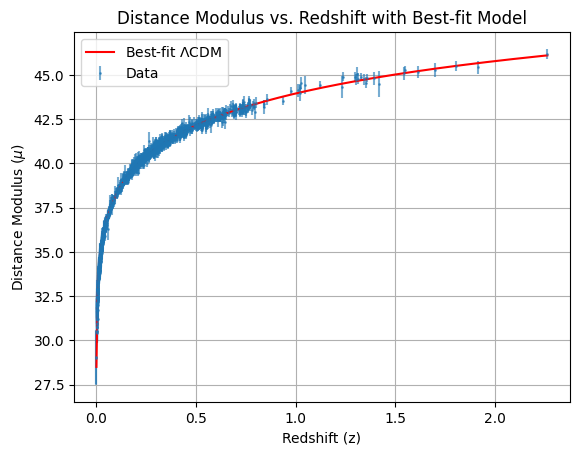

In [8]:
plt.errorbar(z, mu, yerr=mu_err, fmt='o', markersize=1, label='Data', alpha=0.6)    # plot the data with error bars

z_fit = np.linspace(z.min(), z.max(), 500)  #generate 500 points between min and max redshift for smooth curve
mu_fit = mu_theory(z_fit, *popt)    #calculate the theoretical distance modulus for these z values

plt.plot(z_fit, mu_fit, color='red', label=r'Best-fit $\Lambda$CDM')    # plot the best-fit model

plt.xlabel('Redshift (z)')
plt.ylabel(r'Distance Modulus ($\mu$)')
plt.title('Distance Modulus vs. Redshift with Best-fit Model')
plt.legend()
plt.grid()
plt.show()

Now that we have the best-fit values of $ H_0 $ and $ \Omega_m $, we can estimate the age of the universe. This is done by integrating the inverse of the Hubble parameter over redshift:

$$
t_0 = \int_0^\infty \frac{1}{(1 + z) H(z)} \, dz
$$

We convert $ H_0 $ to SI units and express the result in gigayears (Gyr). This provides an independent check on our cosmological model by comparing the estimated age to values from other probes like Planck CMB measurements.

In [9]:
def age_of_universe(H0_km_s_Mpc, Omega_m):
    H0 = H0_km_s_Mpc * u.km / u.s / u.Mpc   # convert H0 to astropy units
    integral, _ = quad(lambda z: 1 / ((1 + z) * E(z, Omega_m)), 0, np.inf)  # integrate using the quad function we defined earlier
    # The age of the universe in seconds is given by the integral divided by H0
    # H0 is in units of 1/s, so we need to convert it to 1/H0 to get time in seconds
    
    age_sec = integral / H0  # units: 1 / H0 ⇒ time
    age_gyr = age_sec.to(u.Gyr) # convert seconds to gigayears
    # Return the age in gigayears
    return age_gyr.value

age = age_of_universe(popt[0], popt[1])    #calculate the age of the universe using the fitted H0 and Omega_m
print(f"Age of the Universe: {age:.2f} Gyr") 



Age of the Universe: 12.36 Gyr


## What if we fix $\Omega_m = 0.3$?

Instead of using the optimized parameter, that was attained by fitting the cosmological model to the dataset, we will try fixing the matter density parameter to 0.3. We will analyse how exactly this affects the value of H.

Fitted H0 with fixed Omega_m = 0.3: 73.53 ± 0.17 km/s/Mpc


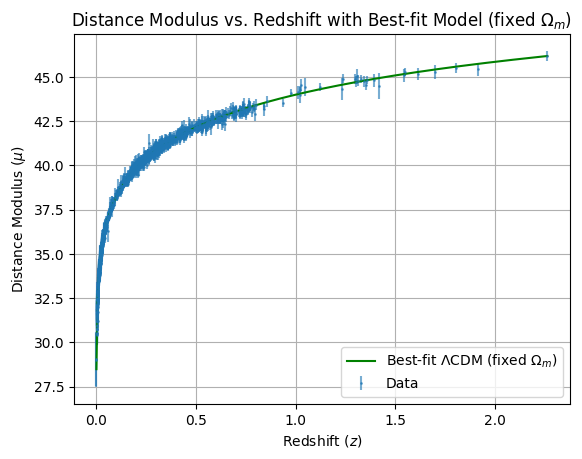

In [10]:
#fixed omega_m = 0.3
def mu_fixed_Om(z, H0):
    return mu_theory(z, H0, Omega_m=0.3)
# Perform the curve fit with fixed Omega_m
popt_fixed_Om, pcov_fixed_Om = curve_fit(
    mu_fixed_Om,    #theoretical model function with fixed Omega_m
    z,
    mu,
    sigma=mu_err,
    p0=[70],    #initial guess for H0
    absolute_sigma=True,
    maxfev=10000
)
perr_fixed_Om = np.sqrt(np.diag(pcov_fixed_Om))
print(f"Fitted H0 with fixed Omega_m = 0.3: {popt_fixed_Om[0]:.2f} ± {perr_fixed_Om[0]:.2f} km/s/Mpc")

# Plot the data with error bars and the best-fit model with fixed Omega_m
plt.errorbar(z, mu, yerr=mu_err, fmt='o', markersize=1, label='Data', alpha=0.6)

# Generate smooth z values for the fit curve with fixed Omega_m
z_fit_fixed_Om = np.linspace(z.min(), z.max(), 500)
mu_fit_fixed_Om = mu_fixed_Om(z_fit_fixed_Om, *popt_fixed_Om)

# Use raw strings for LaTeX to avoid invalid escape sequence warnings
plt.plot(z_fit_fixed_Om, mu_fit_fixed_Om, color='green', label=r'Best-fit $\Lambda$CDM (fixed $\Omega_m$)')
plt.xlabel(r'Redshift ($z$)')
plt.ylabel(r'Distance Modulus ($\mu$)')
plt.title(r'Distance Modulus vs. Redshift with Best-fit Model (fixed $\Omega_m$)')

plt.legend()
plt.grid()
plt.show()

In [11]:
#age of universe with fixed Omega_m
age_fixed_Om = age_of_universe(popt_fixed_Om[0], 0.3)
print(f"Age of the Universe with fixed Omega_m = 0.3: {age_fixed_Om:.2f} Gyr")

Age of the Universe with fixed Omega_m = 0.3: 12.82 Gyr


## Analysing Residuals

To evaluate how well our cosmological model fits the data, we compute the residuals:

$$
\text{Residual} = \mu_{\text{obs}} - \mu_{\text{model}}
$$

Plotting these residuals against redshift helps identify any systematic trends, biases, or outliers. A good model fit should show residuals scattered randomly around zero without any significant structure.

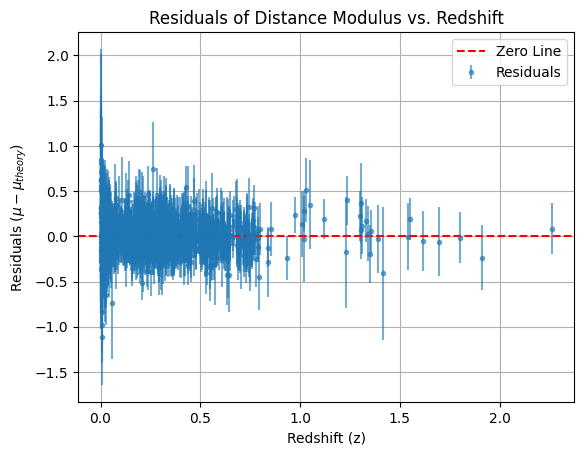

In [12]:
residual =  mu - mu_theory(z, *popt)    #Define the residuals as the difference between observed and theoretical distance modulus
plt.errorbar(z, residual, yerr=mu_err, fmt='o', markersize=3, label='Residuals', alpha=0.6) #error bar plot of residuals
plt.axhline(0, color='red', linestyle='--', label='Zero Line')  # horizontal line at zero for reference
plt.xlabel('Redshift (z)')
plt.ylabel(r'Residuals ($\mu - \mu_{theory}$)')
plt.title('Residuals of Distance Modulus vs. Redshift')
plt.legend()
plt.grid()
plt.show()

## Comparing Low-$z$ and High-$z$ Subsamples

Finally, we examine whether the inferred value of $H_0$ changes with redshift by splitting the dataset into:

- **Low-z** supernovae ($ z < 0.1 $)
- **High-z** supernovae ($ z \geq 0.1 $)

We then fit each subset separately (keeping $ \Omega_m = 0.3 $) to explore any potential tension or trend with redshift.


In [16]:
a1 = 0.1  # Define the redshift bin threshold

z_bin1 = z[z < a1]  # Redshift values for the first bin
z_bin2 = z[z >= a1] # Redshift values for the second bin
mu_bin1 = mu[z < a1]    # Distance modulus values for the first bin
mu_bin2 = mu[z >= a1]   # Distance modulus values for the second bin
mu_err_bin1 = mu_err[z < a1]    # Errors in distance modulus for the first bin
mu_err_bin2 = mu_err[z >= a1]   # Errors in distance modulus for the second bin

# Fit the first bin
popt_bin1, pcov_bin1 = curve_fit(   #Curve fitting for the first bin
    mu_fixed_Om,    # theoretical model function with fixed Omega_m
    z_bin1, # redshift values for the first bin
    mu_bin1,  # distance modulus values for the first bin
    sigma=mu_err_bin1,  # errors in distance modulus for the first bin
    p0=[70],
    absolute_sigma=True,
    maxfev=10000
)
perr_bin1 = np.sqrt(np.diag(pcov_bin1))

# Print the fitted parameters for first bin
print(f"Fitted H0 for z < {a1}: {popt_bin1[0]:.2f} ± {perr_bin1[0]:.2f} km/s/Mpc")

Fitted H0 for z < 0.1: 73.01 ± 0.28 km/s/Mpc


Let us do the same for the second bin, for the mere purpose of analysing whether or not there is a difference, and hence the potential reasons for so. 

In [14]:
# Fit the second bin
popt_bin2, pcov_bin2 = curve_fit(   #Curve fitting for the second bin
    mu_fixed_Om,    # theoretical model function with fixed Omega_m
    z_bin2, # similar to the first bin, but for z >= a1
    mu_bin2,
    sigma=mu_err_bin2,
    p0=[70],
    absolute_sigma=True,
    maxfev=10000
)
perr_bin2 = np.sqrt(np.diag(pcov_bin2))

# Print the fitted parameters for second bin
print(f"Fitted H0 for z >= {a1}: {popt_bin2[0]:.2f} ± {perr_bin2[0]:.2f} km/s/Mpc")

Fitted H0 for z >= 0.1: 73.85 ± 0.22 km/s/Mpc
